# Floodscan pixels

<!-- markdownlint-disable MD013 -->

Grab Floodscan pixels along Benue in Adamawa. We need to do this because the NiHSA observational river level data is so patchy, so we can instead use the observed flood extent along the river as a proxy for the river level.

In [2]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [3]:
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

from src.datasources import floodscan, hydrosheds
from src.utils import blob

## Load data

### Benue river

In [42]:
benue = hydrosheds.load_benue_aoi()

<Axes: >

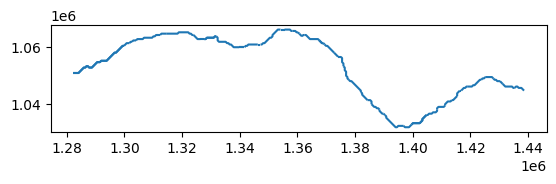

In [48]:
benue.to_crs(3857).plot()

In [57]:
benue_buffer = benue.to_crs(3857).buffer(10 * 1000).to_crs(4326)

<Axes: >

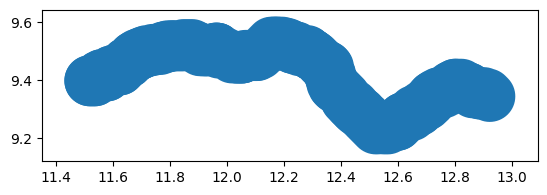

In [58]:
benue_buffer.plot()

### Floodscan

#### Old `.nc` file

In [23]:
fs_old = floodscan.load_raw_nga_floodscan()

In [59]:
fs_old = fs_old.rio.write_crs(4326)

In [143]:
fs_old_clip = fs_old.rio.clip(benue_buffer.geometry)

In [144]:
df_fs_old = fs_old_benue.to_dataframe()["SFED_AREA"].reset_index().dropna()
df_fs_old

,lat,lon,time,SFED_AREA
18970,9.541667,11.625,1998-01-12,0.0
18971,9.541667,11.625,1998-01-13,0.0
18972,9.541667,11.625,1998-01-14,0.0
18973,9.541667,11.625,1998-01-15,0.0
18974,9.541667,11.625,1998-01-16,0.0
...,...,...,...,...
863130,9.208333,12.625,2023-12-27,0.0
863131,9.208333,12.625,2023-12-28,0.0
863132,9.208333,12.625,2023-12-29,0.0
863133,9.208333,12.625,2023-12-30,0.0


In [145]:
df_fs_old.nunique()

lat              5
lon             18
time          9485
SFED_AREA    32587
dtype: int64

#### New COGs

In [18]:
blob_name_format = (
    "floodscan/daily/v5/processed/aer_area_300s_v{date_str}_v05r01.tif"
)

In [25]:
dates = pd.date_range("2024-01-01", "2024-12-31")

In [20]:
blob_names = [blob_name_format.format(date_str=x.date()) for x in dates]

In [108]:
das = []
for date in tqdm(dates):
    blob_name = blob_name_format.format(date_str=date.date())
    da_in = stratus.open_blob_cog(
        blob_name, stage="prod", container_name="raster"
    )
    da_in = da_in.sel(band=1).drop_vars("band")
    da_in["date"] = date
    das.append(da_in)

  0%|          | 0/366 [00:00<?, ?it/s]

In [109]:
fs_new = xr.concat(das, dim="date")

In [111]:
fs_new

<xarray.DataArray (date: 366, y: 1080, x: 1080)> Size: 2GB
dask.array<concatenate, shape=(366, 1080, 1080), dtype=float32, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 9kB -29.96 -29.88 -29.79 ... 59.79 59.88 59.96
  * y            (y) float64 9kB 39.96 39.88 39.79 ... -49.79 -49.88 -49.96
    spatial_ref  int64 8B 0
  * date         (date) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
Attributes: (12/19)
    AREA_OR_POINT:     Area
    averaging_period:  daily
    date_issued:       None
    date_valid:        1
    download_date:     2024-11-01
    grid_resolution:   0.08333
    ...                ...
    version:           5
    year_issued:       None
    year_valid:        2024
    scale_factor:      1.0
    add_offset:        0.0
    long_name:         ('SFED', 'MFED')

In [112]:
fs_new_clip = fs_new.rio.clip(benue_buffer.geometry)

<Axes: title={'center': 'time = 2022-08-24, spatial_ref = 0, crs = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

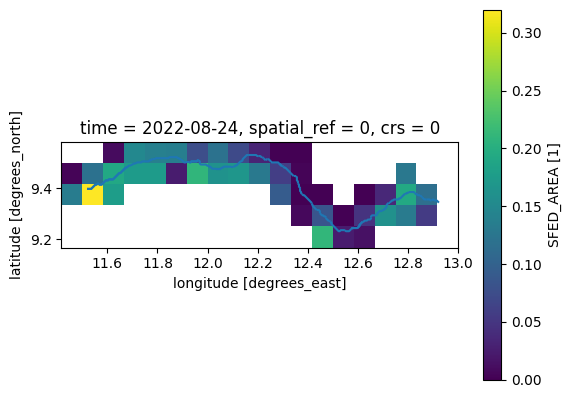

In [118]:
fig, ax = plt.subplots()
fs_old_clip.sel(time="2022-08-24").plot(ax=ax)
benue.plot(ax=ax)

<Axes: title={'center': 'date = 2024-02-01, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

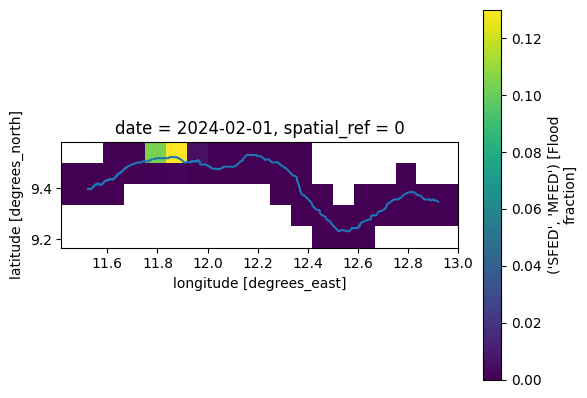

In [113]:
fig, ax = plt.subplots()
fs_new_clip.sel(date="2024-02-01").plot()
benue.plot(ax=ax)

### Merge old and new Floodscan

In [114]:
with ProgressBar():
    df_fs_new_raw = fs_new_clip.to_dataframe(name="SFED")

[########################################] | 100% Completed | 86.42 s


In [115]:
df_fs_new = df_fs_new_raw["SFED"].reset_index().dropna()

In [116]:
df_fs_new

,date,y,x,SFED
2,2024-01-01,9.541667,11.625000,0.0
3,2024-01-01,9.541667,11.708333,0.0
4,2024-01-01,9.541667,11.791667,0.0
5,2024-01-01,9.541667,11.875000,0.0
6,2024-01-01,9.541667,11.958333,0.0
...,...,...,...,...
34749,2024-12-31,9.291667,12.875000,0.0
34750,2024-12-31,9.291667,12.958333,0.0
34763,2024-12-31,9.208333,12.458333,0.0
34764,2024-12-31,9.208333,12.541667,0.0


Check if same pixels in each

In [125]:
df_fs_old.nunique()

lat              5
lon             18
time          9485
SFED_AREA    32587
dtype: int64

In [126]:
df_fs_new.nunique()

date     366
y          5
x         19
SFED    5070
dtype: int64

In [136]:
df_fs_new["x"].round(4)

2        11.6250
3        11.7083
4        11.7917
5        11.8750
6        11.9583
          ...   
34749    12.8750
34750    12.9583
34763    12.4583
34764    12.5417
34765    12.6250
Name: x, Length: 16470, dtype: float64

Combine `df`s, and found pixel coords so they line up

In [138]:
df_fs_combined = pd.concat(
    [
        df_fs_old.rename(
            columns={
                "time": "date",
                "lat": "y",
                "lon": "x",
                "SFED_AREA": "SFED",
            }
        ),
        df_fs_new,
    ]
)
df_fs_combined["x"] = df_fs_combined["x"].round(4)
df_fs_combined["y"] = df_fs_combined["y"].round(4)

In [148]:
df_fs_combined.groupby(["x", "y"]).size()

x        y     
11.4583  9.3750    9851
         9.4583    9851
11.5417  9.3750    9851
         9.4583    9851
11.6250  9.3750    9851
         9.4583    9851
         9.5417    9851
11.7083  9.4583    9851
         9.5417    9851
11.7917  9.4583    9851
         9.5417    9851
11.8750  9.4583    9851
         9.5417    9851
11.9583  9.4583    9851
         9.5417    9851
12.0417  9.4583    9851
         9.5417    9851
12.1250  9.4583    9851
         9.5417    9851
12.2083  9.4583    9851
         9.5417    9851
12.2917  9.3750    9851
         9.4583    9851
         9.5417    9851
12.3750  9.2917    9851
         9.3750    9851
         9.4583    9851
         9.5417    9851
12.4583  9.2083    9851
         9.2917    9851
         9.3750    9851
12.5417  9.2083    9851
         9.2917    9851
12.6250  9.2083    9851
         9.2917    9851
         9.3750    9851
12.7083  9.2917    9851
         9.3750    9851
12.7917  9.2917    9851
         9.3750    9851
         9.4583    9851


Drop pixel that is missing

In [150]:
df_fs_combined = df_fs_combined[df_fs_combined["x"] != 12.9583]

Double-check all pixels are there for all dates

In [151]:
df_fs_combined.groupby(["x", "y"]).size()

x        y     
11.4583  9.3750    9851
         9.4583    9851
11.5417  9.3750    9851
         9.4583    9851
11.6250  9.3750    9851
         9.4583    9851
         9.5417    9851
11.7083  9.4583    9851
         9.5417    9851
11.7917  9.4583    9851
         9.5417    9851
11.8750  9.4583    9851
         9.5417    9851
11.9583  9.4583    9851
         9.5417    9851
12.0417  9.4583    9851
         9.5417    9851
12.1250  9.4583    9851
         9.5417    9851
12.2083  9.4583    9851
         9.5417    9851
12.2917  9.3750    9851
         9.4583    9851
         9.5417    9851
12.3750  9.2917    9851
         9.3750    9851
         9.4583    9851
         9.5417    9851
12.4583  9.2083    9851
         9.2917    9851
         9.3750    9851
12.5417  9.2083    9851
         9.2917    9851
12.6250  9.2083    9851
         9.2917    9851
         9.3750    9851
12.7083  9.2917    9851
         9.3750    9851
12.7917  9.2917    9851
         9.3750    9851
         9.4583    9851


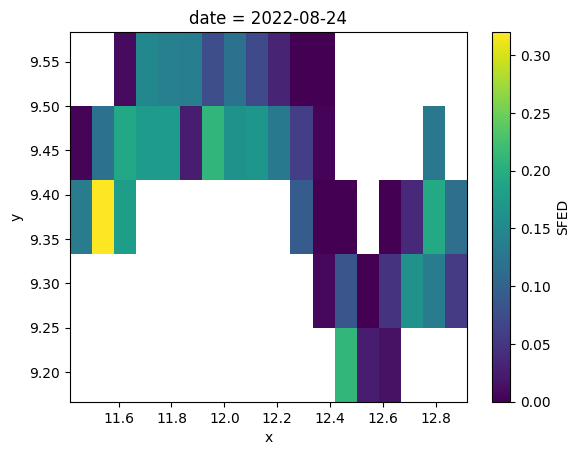

In [167]:
df_fs_combined.set_index(["date", "y", "x"]).to_xarray().sel(
    date="2022-08-24"
)["SFED"].plot()

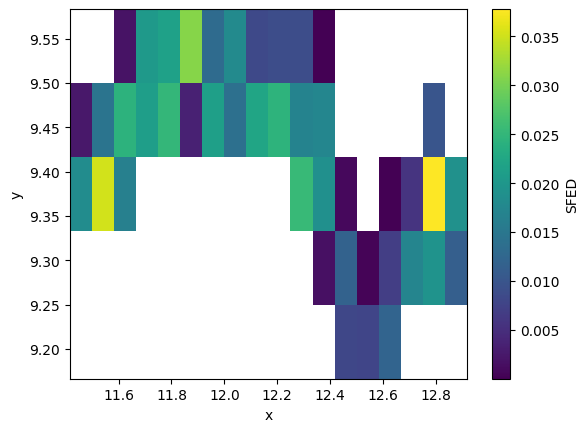

In [172]:
df_fs_combined.groupby(["y", "x"])["SFED"].mean().to_xarray().plot()

In [177]:
df_fs_combined.pivot(columns=["x", "y"], index="date").corr()

SFED                                          \
x                     11.6250   11.7083   11.7917   11.8750   11.9583   
y                      9.5417    9.5417    9.5417    9.5417    9.5417   
     x       y                                                          
SFED 11.6250 9.5417  1.000000  0.907939  0.800782  0.786760  0.737584   
     11.7083 9.5417  0.907939  1.000000  0.869257  0.796112  0.742633   
     11.7917 9.5417  0.800782  0.869257  1.000000  0.865900  0.789883   
     11.8750 9.5417  0.786760  0.796112  0.865900  1.000000  0.875718   
     11.9583 9.5417  0.737584  0.742633  0.789883  0.875718  1.000000   
     12.0417 9.5417  0.750902  0.763790  0.793901  0.812298  0.843436   
     12.1250 9.5417  0.746436  0.757247  0.757874  0.728240  0.746890   
     12.2083 9.5417  0.756236  0.754780  0.757435  0.727231  0.736476   
     12.2917 9.5417  0.761780  0.738635  0.729744  0.713988  0.718504   
     12.3750 9.5417  0.589573  0.507407  0.505960  0.531709  0.553565   
     11.4583 9.4583  0.508884  0.461007  0.394508  0.419438  0.399672   
     11.5417 9.4583  0.785127  0.851794  0.806077  0.742023  0.738742   
     11.6250 9.4583  0.850053  0.881165  0.861795  0.806987  0.791456   
     11.7083 9.4583  0.851039  0.900507  0.871875  0.817338  0.785291   
     11.7917 9.4583  0.758885  0.814998  0.832246  0.761591  0.757778   
     11.8750 9.4583  0.767728  0.756873  0.764687  0.765195  0.768421   
     11.9583 9.4583  0.731165  0.770004  0.779257  0.743916  0.762401   
     12.0417 9.4583  0.751992  0.778046  0.774555  0.738851  0.759195   
     12.1250 9.4583  0.690798  0.726216  0.778411  0.736172  0.724042   
     12.2083 9.4583  0.661357  0.703922  0.761562  0.712873  0.708039   
     12.2917 9.4583  0.668738  0.682731  0.732567  0.709055  0.703651   
     12.3750 9.4583  0.566127  0.587806  0.649495  0.637816  0.619800   
     12.7917 9.4583  0.447383  0.464773  0.424829  0.420439  0.443045   
     11.4583 9.3750  0.812322  0.836153  0.813181  0.777115  0.776988   
     11.5417 9.3750  0.796919  0.856906  0.822487  0.767548  0.758579   
     11.6250 9.3750  0.785957  0.813345  0.799015  0.763877  0.771193   
     12.2917 9.3750  0.343142  0.362449  0.428621  0.457917  0.468178   
     12.3750 9.3750  0.620744  0.647387  0.696987  0.666864  0.634420   
     12.4583 9.3750  0.654650  0.654359  0.628390  0.608534  0.597562   
     12.6250 9.3750  0.593221  0.596721  0.576631  0.558577  0.550397   
     12.7083 9.3750  0.731118  0.743927  0.712794  0.679254  0.690116   
     12.7917 9.3750  0.583237  0.637727  0.671261  0.618272  0.630234   
     12.8750 9.3750  0.624497  0.655145  0.681694  0.649088  0.669763   
     12.3750 9.2917  0.500673  0.526926  0.560624  0.533701  0.504556   
     12.4583 9.2917  0.684214  0.713994  0.694437  0.662459  0.657493   
     12.5417 9.2917  0.673469  0.680186  0.672795  0.649654  0.651501   
     12.6250 9.2917  0.621803  0.661615  0.653434  0.609413  0.628477   
     12.7083 9.2917  0.656830  0.713994  0.693137  0.632200  0.644789   
     12.7917 9.2917  0.581316  0.632061  0.669934  0.608762  0.619680   
     12.8750 9.2917  0.589262  0.654141  0.677255  0.616065  0.634011   
     12.4583 9.2083  0.612775  0.614222  0.571182  0.549834  0.543941   
     12.5417 9.2083  0.632849  0.657999  0.661546  0.620652  0.617018   
     12.6250 9.2083  0.512426  0.534248  0.557758  0.540054  0.573205   

                                                                       ...  \
x                     12.0417   12.1250   12.2083   12.2917   12.3750  ...   
y                      9.5417    9.5417    9.5417    9.5417    9.5417  ...   
     x       y                                                         ...   
SFED 11.6250 9.5417  0.750902  0.746436  0.756236  0.761780  0.589573  ...   
     11.7083 9.5417  0.763790  0.757247  0.754780  0.738635  0.507407  ...   
     11.7917 9.5417  0.793901  0.757874  0.757435  0.729744  0.505960  ...   
     11.8750 9.5417  0.812298  0.728240  0.7272

In [178]:
df_fs_combined.dtypes

y              float64
x              float64
date    datetime64[ns]
SFED           float32
dtype: object

## Write to blob

In [4]:
import src.constants

blob_name = f"{src.constants.PROJECT_PREFIX}/processed/floodscan/fs_benue_pixels_1998_2024.parquet"

In [5]:
blob_name

'ds-aa-nga-flooding/processed/floodscan/fs_benue_pixels_1998_2024.parquet'

In [181]:
stratus.upload_parquet_to_blob(df_fs_combined, blob_name)